<a href="https://colab.research.google.com/github/Fernando1729/2021_1_Viral-Tweets-Prediction/blob/master/Vers%C3%A3o_final_Minera%C3%A7%C3%A3o_CarDekho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SME0878 - Mineração Estatística de Dados (2021)



<center> <b> <font size="+2"> Bruno Ricardo Pereira dos Santos</i> </center>
<center> <b>  <font size="+2"> Fernando Vieira da Silva</i> </center>

<center>  <font size="+1"> 19 de dezembro de 2021
 </center>

 https://www.kaggle.com/rizbaltazar/cardekho-eda-and-predictions/data

In [ ]:
!pip install pandasql
!pip install category_encoders

In [ ]:
!pip install catboost
!pip install shap
#https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

In [ ]:
from catboost.utils import eval_metric
from catboost import CatBoostRegressor, Pool
import shap

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFECV
import re
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format

drive.mount('/content/drive', force_remount=False) 
%cd /content/drive/My Drive/Mineração - Francisco Rodrigues

warnings.filterwarnings(action='once')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZJjwfp5s3gKN2vesER_huueX6zspTrE5/Aprendizado de máquina/Mineração - Francisco Rodrigues


In [ ]:
#from google.colab import files
#files.upload()

{}

In [ ]:
train = pd.read_csv("train_car_details.csv")
test = pd.read_csv("test_car_details.csv")

# Análise dos Dados

In [ ]:
train['year_n'] = 2021 - train['year']
test['year_n'] = 2021 - train['year']

In [ ]:
train.head()

,Id,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,year_n
0,1,Hyundai Santro GLS I - Euro I,1999,80000,110000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,nan,22
1,2,Maruti Ertiga VDI,2012,459999,87000,Diesel,Individual,Manual,First Owner,20.77 kmpl,1248 CC,88.76 bhp,200Nm@ 1750rpm,7.00,9
2,3,BMW 3 Series 320d Luxury Line,2010,1100000,102000,Diesel,Dealer,Automatic,First Owner,19.62 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.00,11
3,4,Tata New Safari DICOR 2.2 EX 4x2,2009,229999,212000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.00,12
4,5,Toyota Fortuner 3.0 Diesel,2010,800000,125000,Diesel,Individual,Manual,Second Owner,11.5 kmpl,2982 CC,171 bhp,343Nm@ 1400-3400rpm,7.00,11


In [ ]:
test.drop('torque', axis=1, inplace=True)

In [ ]:
train.drop('torque', axis=1, inplace=True)

#train.head(4)

In [ ]:
train.isna().sum()

Id                 0
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          157
engine           157
max_power        151
seats            157
year_n             0
dtype: int64

In [ ]:
train.shape

(5689, 14)

In [ ]:
train.describe()

,Id,year,selling_price,km_driven,seats,year_n
count,5689.00,5689.00,5689.00,5689.00,5532.00,5689.00
mean,2845.00,2013.74,627774.40,69877.59,5.42,7.26
std,1642.42,4.05,778400.03,51247.31,0.96,4.05
min,1.00,1983.00,29999.00,1.00,2.00,1.00
25%,1423.00,2011.00,250000.00,35000.00,5.00,4.00
50%,2845.00,2014.00,450000.00,60000.00,5.00,7.00
75%,4267.00,2017.00,667000.00,98000.00,5.00,10.00
max,5689.00,2020.00,7200000.00,1500000.00,10.00,38.00


In [ ]:
train.head(4)

,Id,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,year_n
0,1,Hyundai Santro GLS I - Euro I,1999,80000,110000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,nan,22
1,2,Maruti Ertiga VDI,2012,459999,87000,Diesel,Individual,Manual,First Owner,20.77 kmpl,1248 CC,88.76 bhp,7.00,9
2,3,BMW 3 Series 320d Luxury Line,2010,1100000,102000,Diesel,Dealer,Automatic,First Owner,19.62 kmpl,1995 CC,187.74 bhp,5.00,11
3,4,Tata New Safari DICOR 2.2 EX 4x2,2009,229999,212000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,7.00,12


In [ ]:
train_copy = train.copy()
X = train_copy.drop("selling_price", axis=1)
y = train.selling_price

In [ ]:
X.shape, y.shape

((5689, 13), (5689,))

In [ ]:
X.head()

,Id,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,year_n
0,1,Hyundai Santro GLS I - Euro I,1999,110000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,nan,22
1,2,Maruti Ertiga VDI,2012,87000,Diesel,Individual,Manual,First Owner,20.77 kmpl,1248 CC,88.76 bhp,7.00,9
2,3,BMW 3 Series 320d Luxury Line,2010,102000,Diesel,Dealer,Automatic,First Owner,19.62 kmpl,1995 CC,187.74 bhp,5.00,11
3,4,Tata New Safari DICOR 2.2 EX 4x2,2009,212000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,7.00,12
4,5,Toyota Fortuner 3.0 Diesel,2010,125000,Diesel,Individual,Manual,Second Owner,11.5 kmpl,2982 CC,171 bhp,7.00,11


In [ ]:
cols= ["mileage","engine","max_power"]
for col in cols:
    lista=[]
    for i in X[col]:
        if type(i) == str:
            try:
                lista.append(np.float(i.split(" ")[0]))
            except ValueError:
                lista.append(np.nan)
        else:
            lista.append(np.nan)

    X[col] = lista

In [ ]:
cols= ["mileage","engine","max_power"]
for col in cols:
    lista=[]
    for i in test[col]:
        if type(i) == str:
            try:
                lista.append(np.float(i.split(" ")[0]))
            except ValueError:
                lista.append(np.nan)
        else:
            lista.append(np.nan)

    test[col] = lista

In [ ]:
print("Diferença da média para a mediana na coluna Mileage:",X["mileage"].median() - X["mileage"].mean())
print("Diferença da média para a mediana na coluna Engine:",X["engine"].median() - X["engine"].mean())
print("Diferença da média para a mediana na coluna Max Power:",X["max_power"].median() - X["max_power"].mean())

Diferença da média para a mediana na coluna Mileage: -0.10350325379613423
Diferença da média para a mediana na coluna Engine: -210.4696312364424
Diferença da média para a mediana na coluna Max Power: -9.143597616036274


19.403503253796135
19.3


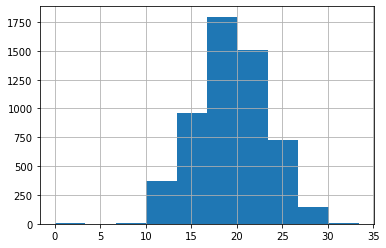

In [ ]:
X["mileage"].hist()
print(X["mileage"].mean())
print(X["mileage"].median());

0
19.40064686236607
19.3


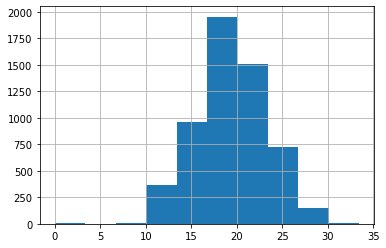

In [ ]:
X["mileage"].fillna(X["mileage"].median(), inplace=True)
test["mileage"].fillna(test["mileage"].median(), inplace=True)
print(X["mileage"].isna().sum())

X["mileage"].hist()
print(X["mileage"].mean())
print(X["mileage"].median());

1458.4696312364424
1248.0


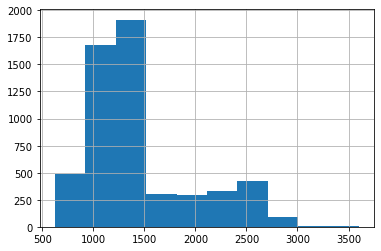

In [ ]:
X["engine"].hist()
print(X["engine"].mean())
print(X["engine"].median());

0
1458.469631236438
1248.0


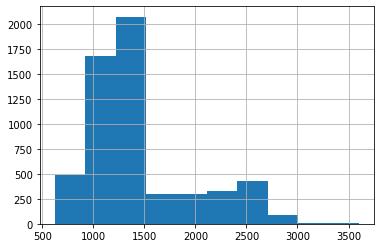

In [ ]:
X["engine"].fillna(X["engine"].mean(), inplace=True)
test["engine"].fillna(test["engine"].mean(), inplace=True)
print(X["engine"].isna().sum())

X["engine"].hist()
print(X["engine"].mean())
print(X["engine"].median());

91.14359761603627
82.0


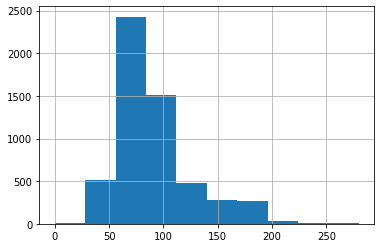

In [ ]:
X["max_power"].hist()
print(X["max_power"].mean())
print(X["max_power"].median());

0
91.14359761603643
83.1


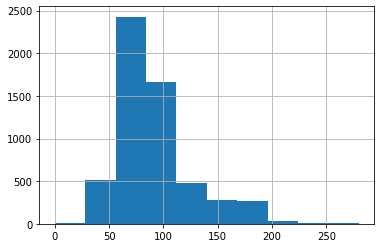

In [ ]:
X["max_power"].fillna(X["max_power"].mean(), inplace=True)
test["max_power"].fillna(test["max_power"].mean(), inplace=True)
print(X["max_power"].isna().sum())

X["max_power"].hist()
print(X["max_power"].mean())
print(X["max_power"].median());

Diferença da média para a mediana na coluna Seats: -0.4229934924078087
5.422993492407809
5.0


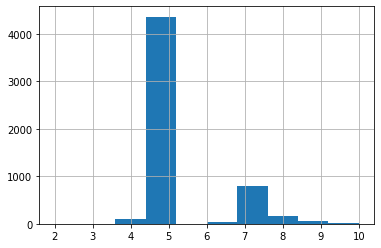

In [ ]:
print("Diferença da média para a mediana na coluna Seats:",X["seats"].median() - X["seats"].mean())
X["seats"].hist()
print(X["seats"].mean())
print(X["seats"].median());

0
5.411320091404464
5.0


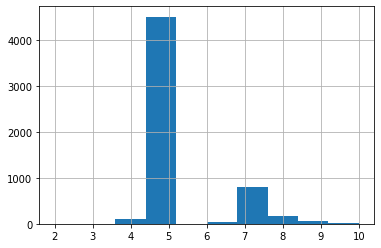

In [ ]:
X["seats"].fillna(X["seats"].median(), inplace=True)
test["seats"].fillna(test["seats"].median(), inplace=True)
print(X["seats"].isna().sum())

X["seats"].hist()
print(X["seats"].mean())
print(X["seats"].median());

# Transformação dos Dados

## Criação de uma nova categoria para a marca do carro, a categoria "Outras" inclui os fabricantes com poucos anúncios no site.

In [ ]:
X_nomes = X["name"]

## Tratando os nomes das marcas de modo a agrupa-los o máximo possível e identificar quais marcas são mais recorrentes no dataset e podem influenciar mais significativamente na predição
for i in range(X_nomes.size):
    X_nomes.iat[i] = X_nomes.iat[i].split(' ')[0]

sub_data = pandasql.sqldf(''' SELECT DISTINCT
                              name,
                              count(name) as qtd
                              from X_nomes
                              GROUP BY name
                              ORDER BY qtd DESC;''')
sub_data['percent'] = round((sub_data['qtd'] / sub_data['qtd'].sum())*100,2)

## Ao filtramos as top 10 marcas e agruparmos o restante, observamos que a décima possui representatividade de um pouco mais de 2%
sub_case_data = pandasql.sqldf(''' SELECT DISTINCT
                                            CASE WHEN percent >= '2' then name
                                                 ELSE 'Outras' end as Marcas,
                                            SUM(qtd) as qtd_total,
                                            SUM(percent) as percent_total
                                  FROM sub_data
                                  GROUP BY Marcas
                                  ORDER BY qtd_total DESC;''')

for i in sub_data.index:
    if sub_data["percent"][i] <= 2:
        sub_data["name"][i] = "Outras"

lista = list(sub_data["name"][0:10])

for i in X.index:
    if X["name"][i] not in lista:
        X['name'][i] = "Outras"

In [ ]:
test_nomes = test["name"]

## Tratando os nomes das marcas de modo a agrupa-los o máximo possível e identificar quais marcas são mais recorrentes no dataset e podem influenciar mais significativamente na predição
for i in range(test_nomes.size):
    test_nomes.iat[i] = test_nomes.iat[i].split(' ')[0]

sub_data1 = pandasql.sqldf(''' SELECT DISTINCT
                              name,
                              count(name) as qtd
                              from test_nomes
                              GROUP BY name
                              ORDER BY qtd DESC;''')
sub_data1['percent'] = round((sub_data1['qtd'] / sub_data1['qtd'].sum())*100,2)

## Ao filtramos as top 10 marcas e agruparmos o restante, observamos que a décima possui representatividade de um pouco mais de 2%
sub_case_data1 = pandasql.sqldf(''' SELECT DISTINCT
                                            CASE WHEN percent >= '2' then name
                                                 ELSE 'Outras' end as Marcas,
                                            SUM(qtd) as qtd_total,
                                            SUM(percent) as percent_total
                                  FROM sub_data1
                                  GROUP BY Marcas
                                  ORDER BY qtd_total DESC;''')

for i in sub_data1.index:
    if sub_data1["percent"][i] <= 2:
        sub_data1["name"][i] = "Outras"

lista1 = list(sub_data1["name"][0:10])

for i in test.index:
    if test["name"][i] not in lista:
        test["name"][i] = "Outras"

/usr/local/lib/python3.7/dist-packages/pandas/io/sql.py:1431: SADeprecationWarning: The Connection.run_callable() method is deprecated and will be removed in a future release.  Invoke the callable function directly, passing the Connection. (deprecated since: 1.4)
  self.connectable.dialect.has_table, name, schema or self.meta.schema
/usr/local/lib/python3.7/dist-packages/pandas/io/sql.py:717: SADeprecationWarning: Table.tometadata() is renamed to Table.to_metadata() (deprecated since: 1.4)
  self.table = self.table.tometadata(self.pd_sql.meta)
/usr/local/lib/python3.7/dist-packages/pandas/io/sql.py:1431: SADeprecationWarning: The Connection.run_callable() method is deprecated and will be removed in a future release.  Invoke the callable function directly, passing the Connection. (deprecated since: 1.4)
  self.connectable.dialect.has_table, name, schema or self.meta.schema
/usr/local/lib/python3.7/dist-packages/pandas/io/sql.py:1431: SADeprecationWarning: The Connection.run_callable() m

# Gráfico de Pizza (Marcas dos carrros + "Outras")

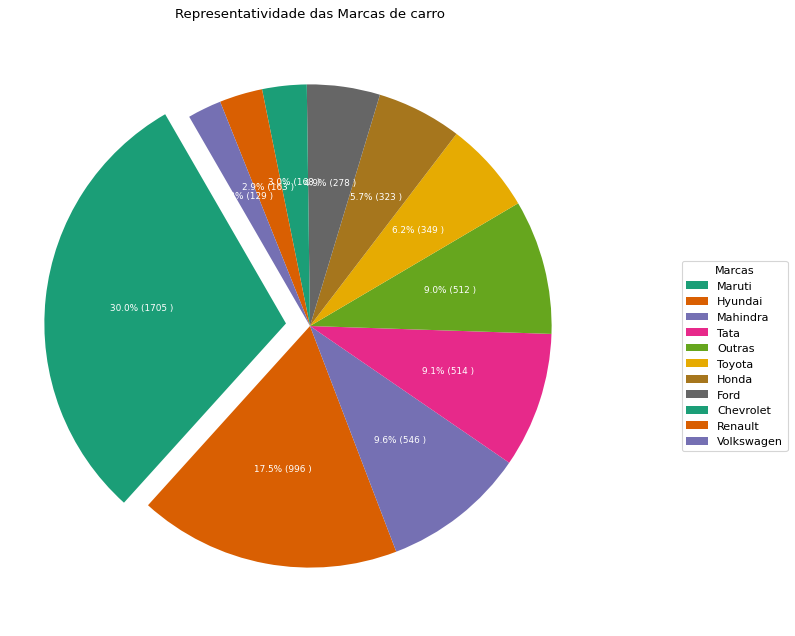

In [ ]:
df = sub_case_data
# Draw Plot
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(aspect="equal"), dpi= 80)
data = df['qtd_total']
categories = df['Marcas']
explode = [0.1,0,0,0,0,0,0,0,0,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                  startangle=120,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Marcas", loc="center right", bbox_to_anchor=(0.9, 0, 0.4, 0.9))
plt.setp(autotexts, size=8, weight=400)
ax.set_title("Representatividade das Marcas de carro")
plt.show()

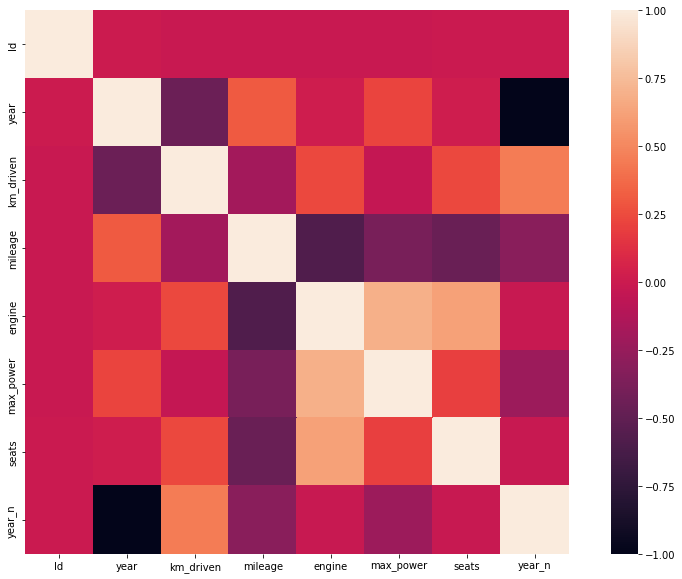

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(),square=True)
plt.show();

In [ ]:
X = pd.get_dummies(X,columns=["fuel","seller_type","transmission","owner"])
test = pd.get_dummies(test,columns=["fuel","seller_type","transmission","owner"])
X.head(5)

,Id,name,year,km_driven,mileage,engine,max_power,seats,year_n,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,1,Hyundai,1999,110000,19.30,1458.47,91.14,5.00,22,0,0,0,1,0,1,0,0,1,0,0,1,0,0
1,2,Maruti,2012,87000,20.77,1248.00,88.76,7.00,9,0,1,0,0,0,1,0,0,1,1,0,0,0,0
2,3,Outras,2010,102000,19.62,1995.00,187.74,5.00,11,0,1,0,0,1,0,0,1,0,1,0,0,0,0
3,4,Tata,2009,212000,11.57,2179.00,138.10,7.00,12,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,5,Toyota,2010,125000,11.50,2982.00,171.00,7.00,11,0,1,0,0,0,1,0,0,1,0,0,1,0,0


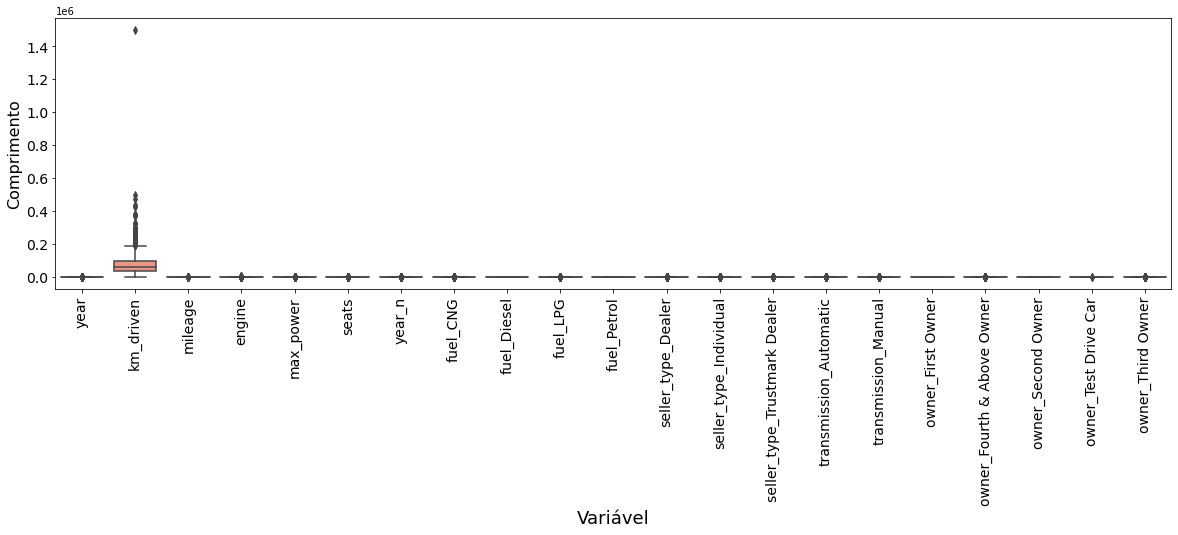

In [ ]:
atributes = X[X.columns[1:len(X)-1]]

plt.figure(figsize=(20, 5))

sns.boxplot(data=atributes)
plt.xlabel('Variável', fontsize=18)
plt.ylabel('Comprimento', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)
plt.show(True)

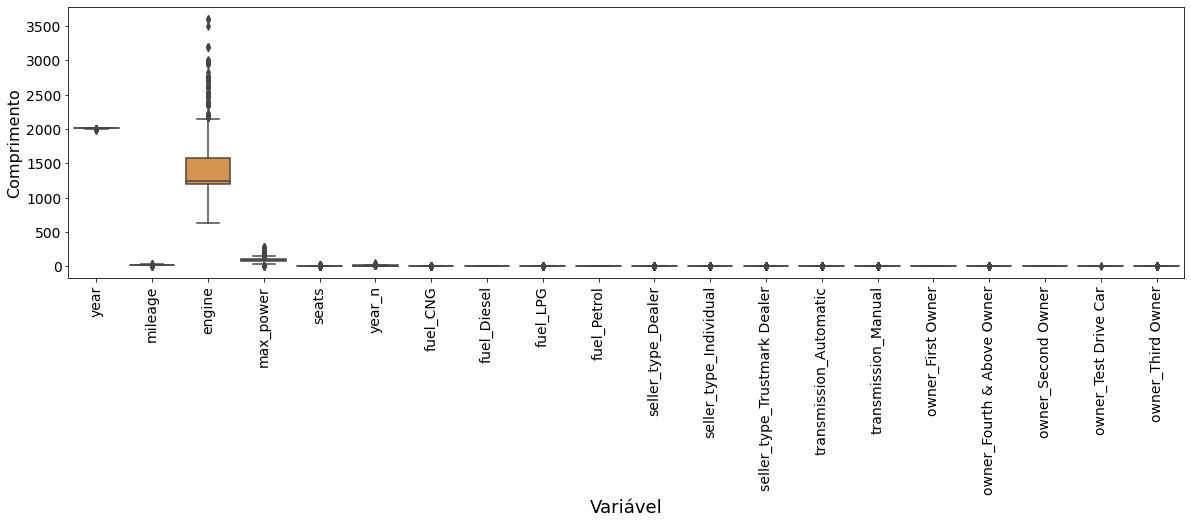

In [ ]:
X_ = X.loc[:, X.columns != 'km_driven']
atributes = X_[X_.columns[1:len(X_)-1]]

plt.figure(figsize=(20, 5))

sns.boxplot(data=atributes)
plt.xlabel('Variável', fontsize=18)
plt.ylabel('Comprimento', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)
plt.show(True)



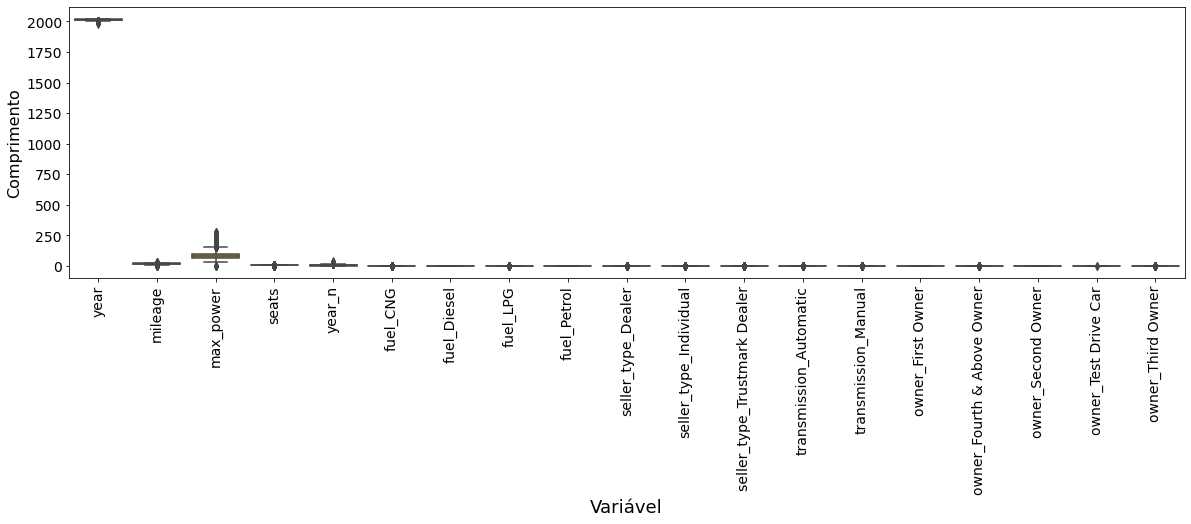

In [ ]:
X_1 = X_.loc[:, X_.columns != 'engine']
atributes = X_1[X_1.columns[1:len(X_1)-1]]

plt.figure(figsize=(20, 5))

sns.boxplot(data=atributes)
plt.xlabel('Variável', fontsize=18)
plt.ylabel('Comprimento', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)
plt.show(True)


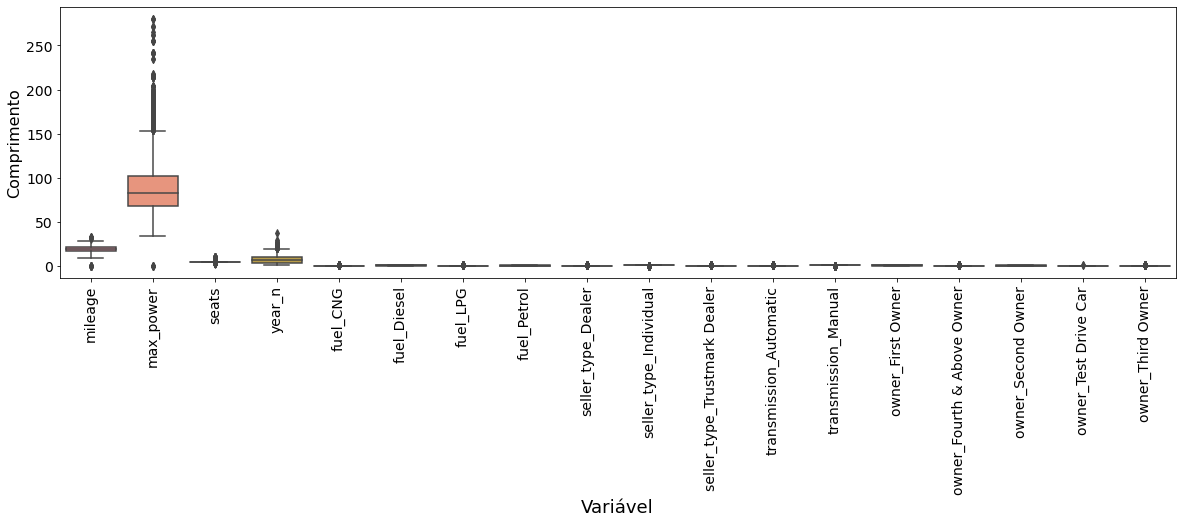

In [ ]:
X_2 = X_1.loc[:, X_1.columns != 'year']
atributes = X_2[X_2.columns[1:len(X_2)-1]]

plt.figure(figsize=(20, 5))

sns.boxplot(data=atributes)
plt.xlabel('Variável', fontsize=18)
plt.ylabel('Comprimento', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)
plt.show(True)

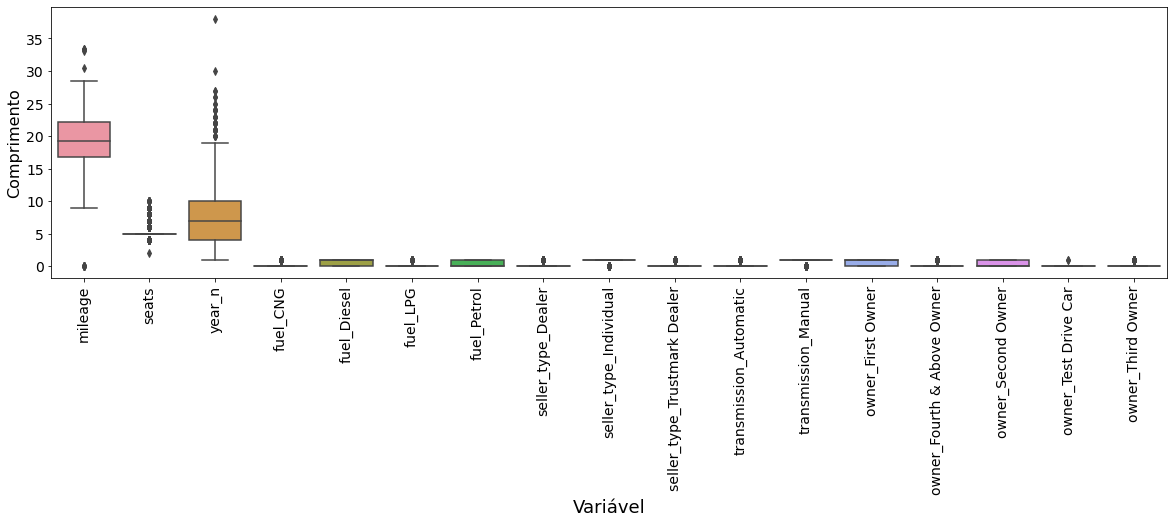

In [ ]:
X_3 = X_2.loc[:, X_2.columns != 'max_power']
atributes = X_3[X_3.columns[1:len(X_3)-1]]

plt.figure(figsize=(20, 5))

sns.boxplot(data=atributes)
plt.xlabel('Variável', fontsize=18)
plt.ylabel('Comprimento', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)
plt.show(True)

In [ ]:
test.head(5)

,Id,name,year,km_driven,mileage,engine,max_power,seats,year_n,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,1,Tata,2008,60000,17.00,1405.00,70.00,5.00,22,0,1,0,0,0,1,0,0,1,0,0,0,0,1
1,2,Maruti,2019,30000,21.40,1197.00,83.10,5.00,9,0,0,0,1,0,1,0,0,1,1,0,0,0,0
2,3,Maruti,2017,80000,28.40,1248.00,74.02,5.00,11,0,1,0,0,0,1,0,1,0,1,0,0,0,0
3,4,Mahindra,2018,30000,16.00,2179.00,140.00,7.00,12,0,1,0,0,0,1,0,0,1,1,0,0,0,0
4,5,Hyundai,2019,35000,18.60,1197.00,81.86,5.00,11,0,0,0,1,0,1,0,0,1,1,0,0,0,0


In [ ]:
encoder = TargetEncoder()
X['name'] = encoder.fit_transform(X['name'],y)

### Apenas as variáves numéricas "year" e "year_n" apresentaram uma correlação alta e decidimos eliminar "year_n", são a mesma variável no final das contas.

### As outras são categóricas e decidimos mantê-las.

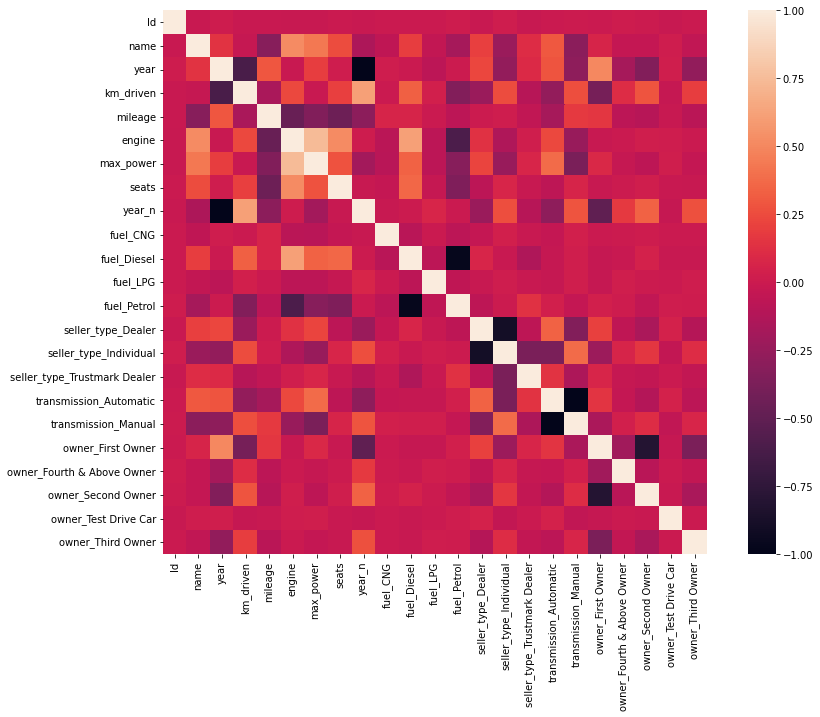

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr("spearman"), square=True)
plt.show();

In [ ]:
dropped = ["Id",'year_n']
dropped2 = ["Id",'year_n']
used = ['name','fuel_Diesel',"seller_type_Dealer",'transmission_Automatic','mileage','year','km_driven','seats', 'engine', 'max_power', 'fuel_CNG', 'fuel_LPG', 'fuel_Petrol','seller_type_Individual','seller_type_Trustmark Dealer', 'transmission_Manual', 'owner_First Owner','owner_Fourth & Above Owner', 'owner_Second Owner','owner_Test Drive Car', 'owner_Third Owner']

In [ ]:
mms = MinMaxScaler()

X[used] = mms.fit_transform(X[used])
#test[used] = mms.transform(test[used])

In [ ]:
X_t = X.drop(dropped, axis=1)
#test_t = test.drop(dropped2, axis = 1)

In [ ]:
X_t.head(5)

,name,year,km_driven,mileage,engine,max_power,seats,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,0.10,0.43,0.07,0.58,0.28,0.33,0.38,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
1,0.07,0.78,0.06,0.62,0.21,0.32,0.62,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
2,1.00,0.73,0.07,0.59,0.46,0.67,0.38,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
3,0.05,0.70,0.14,0.35,0.52,0.49,0.62,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
4,0.39,0.73,0.08,0.34,0.79,0.61,0.62,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [ ]:
X_t.shape, y.shape

((5689, 21), (5689,))

# Salvando o dataframe já tratado e sem "NaN"

In [ ]:


X_t.to_csv("X_t.csv",  index = False )


y.to_csv("y.csv",  index = False )

In [ ]:
X_t = pd.read_csv("X_t.csv")
y   = pd.read_csv(  "y.csv")

In [ ]:
X = X_t

In [ ]:
X_train,X_val,y_train,y_val = train_test_split( X_t, y, test_size = 0.25, random_state = 1729 )

In [ ]:
lin = LinearRegression()

In [ ]:
lin.fit(X_train,y_train)
y_pred = lin.predict(X_val)
r2_score(y_val,y_pred)



0.6720166324264529

In [ ]:
RSME = mean_squared_error(y_val, y_pred)
print("RSME:", "{:.3e}".format(RSME))          # Calculate the test MSE


RSME: 2.052e+11


In [ ]:
poly_reg = PolynomialFeatures( degree = 2 )
X_poly = poly_reg.fit_transform(X_train)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train)
 
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_val)) 
RSME = mean_squared_error(y_val, y_pred)

print("RSME:", "{:.3e}".format(RSME))   

RSME: 3.768e+30


In [ ]:
poly_reg = PolynomialFeatures( degree = 3 )
X_poly = poly_reg.fit_transform(X_train)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train)
 
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_val)) 
RSME = mean_squared_error(y_val, y_pred)

print("RSME:", "{:.3e}".format(RSME))

RSME: 2.899e+30


In [ ]:
poly_reg = PolynomialFeatures( degree = 4 )
X_poly = poly_reg.fit_transform(X_train)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train)
 
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_val)) 
RSME = mean_squared_error(y_val, y_pred)

print("RSME:", "{:.3e}".format(RSME))

RSME: 8.011e+28


In [ ]:
X_poly = poly4.fit_transform(X_train)
 

lin2 = LinearRegression()
lin2.fit(X_poly, y_train)

y_pred = lin2.predict(poly4.fit_transform(X_val))
r2_score(y_val,y_pred)

-4.312202771113194e+18

In [ ]:
y_val.tail(10)

1373     645000
4447     280000
3848     900000
4709     170000
17       415000
5653    5150000
3413    1225000
5159     894999
1226    2000000
972      650000
Name: selling_price, dtype: int64

In [ ]:
#from sklearn.preprocessing import PolynomialFeatures

X_poly = poly.fit_transform(X)
 
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)

In [ ]:
modelETR = ExtraTreesRegressor()
modelETR.fit(X_train,y_train)
y_pred = modelETR.predict(X_val)
r2_score(y_val,y_pred)

0.9783668724244713

In [ ]:
#X_0 = X_t
#y_0 = y

X_t = X_0
y   = y_0


# Seleção e Regularização

## Regressão Ridge

In [ ]:

ylabel = y_0

data = X_0

In [ ]:
# Converte os dados para numpy para facilitar a manipulação
data = data.to_numpy()
nrow,ncol = data.shape
y = ylabel
X = data

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
p = 0.25 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 1729)

In [ ]:
# modelo de regressão linear múltipla
lm = LinearRegression()
lm.fit(x_train, y_train)

y_pred = lm.predict(x_test)
RSME = mean_squared_error(y_test, y_pred)
print("RSME:", RSME)          # Calculate the test MSE


RSME: 205175500116.96207


In [ ]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test, y_pred)
print('R2:', R2)


R2: 0.6720253958815938


In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

# ajusta o modelo ridge regression
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(x_train, y_train)             # Fit a ridge regression on the training data
y_pred = ridge2.predict(x_test)           # Use this model to predict the test data
RSME = mean_squared_error(y_test, y_pred)

In [ ]:
print("RSME:", "{:.5e}".format(RSME))

RSME: 2.05109e+11


In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

# ajusta o modelo ridge regression
ridge2 = Ridge(alpha = 1, normalize = True)
ridge2.fit(x_train, y_train)             # Fit a ridge regression on the training data
y_pred = ridge2.predict(x_test)           # Use this model to predict the test data
RSME = mean_squared_error(y_test, y_pred)
print("RSME:", "{:.5e}".format(RSME))

RSME: 2.37186e+11


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


# Árvore de Decisão


## "Extra Trees" e CatBoost

In [ ]:
modelETR = ExtraTreesRegressor()
modelETR.fit(X_train,y_train)
y_pred = modelETR.predict(X_val)
RSME = mean_squared_error(y_val, y_pred)

print("RSME:", "{:.3e}".format(RSME))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RSME: 1.329e+10


In [ ]:
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_val, y_val)

In [ ]:
model = CatBoostRegressor(loss_function = 'RMSE')

In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
        
model.grid_search(grid, train_dataset)

In [ ]:
pred = model.predict(X_val)
rmse = (np.sqrt(mean_squared_error(y_val, pred)))
r2 = r2_score(y_val, pred)

print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 112702.77
R2: 0.98


In [ ]:
X_feature_names = X_train.columns

### Variáveis mais importantes no Catboost

Text(0.5, 0, 'CatBoost Feature Importance')

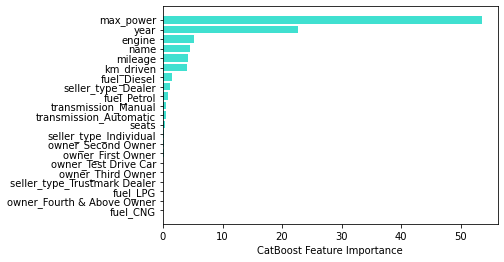

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_feature_names[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

## Esse próximo gráfico lista as variáveis que influenciam para que o preço dos carros seja alto (as primeiras: owner_Fourth & Above Ower, owner_Test Drive Car, etc...) ou mais baixo (as últimas: seller_type_Dealer, name, seats, year...)

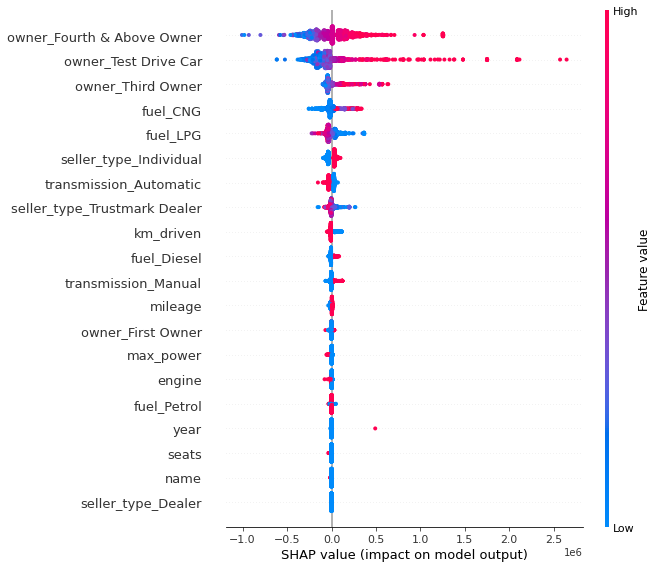

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, feature_names = X_feature_names[sorted_feature_importance])

# CONCLUSÃO

### A variável "torque" estava nos causando muitos problemas, a formatação dela no site era muito diferente, incluia outra variável às vezes (rpm, rotações por minuto) e a unidade de medida também mudava bastante. Depois de observarmos a correlação dela com outras duas variáveis (engine, max_power) era bem alta (0,62 e 0,77, respectivamente) decidimos excluí-la da análise pois a informação presente nela já seria explicada por elas.



### Outra variável que nos deu bastante dor de cabeça foi a "marca" do carro. Existiam muitas opções com poucas unidades disponíveis, por isso resolvemos agrupá-las em uma nova marca que chamamos de "Outras" e isso facilitou bastante a análise.



### As regressões lineares e polinomiais resultaram em erros muito maiores que os modelos obtidos a partir de árvores de decisão, mesmo quando utilizamos a regularização com a regressão Ridge.




### Os melhores modelos que conseguimos encontrar foram: "Extra Trees" e "Catboost Regressor".

### O Catboost nos surpreendeu com o valor do RMSE, muito menor do que todos os modelos que comparamos.

# WebScraping - Selenium


### Tentamos utilizar o "selenium" para obter mais dados e inicialmente tivemos muita dificuldade com o site CarDekho, o site nos assustou um pouco e decidimos procurar um portal de venda de carros mais simples. Encontramos uma empresa chilena (Pompeyo Usados) e a partir daí conseguimos capturar os dados de alguns anúncios.

### Infelizmente não conseguimos repetir o mesmo no site da CarDekho, mas foi questão tempo, a formatação dos anúncios nos deixou confusos mas estamos enviando também o notebook que utilizamos para extrair um pequeno dataframe do outro site, que é bem mais simples, os carros contam apenas com 4 variáveis, isso nos ajudou muito.